# **Unsupervised Learning Project**
## **Topic Modeling**
## **By Yanna Polonia**

# Executive Summary

## <p style='color:navy; text-align:justify'>Handling consumer complaints is crucial for maintaining customer trust, particularly in the financial services industry. However, the high volume of complaints can overwhelm support teams, making it difficult to identify trends and prioritize issues. Manually categorizing complaints is time-consuming and inefficient.</p>

## <p style='color:navy; text-align:justify'>This project applies two topic modeling techniques, Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), to analyze a dataset of consumer complaints from a financial institution, available on <a href='https://www.kaggle.com/datasets/sai1881/cv2-new-nlp'>Kaggle</a> submitted by SAI MANOJ D. The goal is to automatically categorize complaints and provide actionable insights to improve customer service.</p>

## <p style='color:navy; text-align:justify'>Data preprocessing involved text cleaning steps such as lowercasing, tokenization, removing stopwords, punctuation, and irrelevant terms (including numbers and website addresses), followed by lemmatization. LDA and NMF models were developed using both CountVectorizer and TF-IDF Vectorizer, with varying numbers of topics (1, 2, 3, 4, 6, 8, 10).</p>

## <p style='color:navy; text-align:justify'>After evaluating all models, the LDA model with CountVectorizer and 6 topics proved to be the most effective. It struck the best balance between interpretability and performance, producing coherent topics that were directly related to financial themes. This model provides a practical approach for efficiently routing consumer complaints to the appropriate department, thereby improving operational efficiency and customer satisfaction.</p>

In [1]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from time import time
import langdetect  
import matplotlib.pyplot as plt 
%matplotlib inline
import nltk  
import numpy as np 
import pandas as pd
import pyLDAvis 
import pyLDAvis.sklearn
import re
import sklearn 
import warnings # To block deprecation warnings from pyLDAvis
warnings.filterwarnings('ignore') 

# Data Loading

In [2]:
# Loading the dataset into a DataDrame named data
data = pd.read_csv('archive-2/Customer_v2.csv')
data.head()

,Date received,Product,Issue,Consumer complaint narrative,Company public response,State,Submitted via,Consumer disputed?
0,3/23/2015,Credit reporting,Incorrect information on credit report,After looking at my credit report I saw a coll...,Company chooses not to provide a public response,FL,Web,No
1,3/23/2015,Credit reporting,Incorrect information on credit report,I had my purse stolen in 2007. They never foun...,Company chooses not to provide a public response,ME,Web,No
2,3/23/2015,Student loan,Can't repay my loan,This is a continuation of a previous issue wit...,Company chooses not to provide a public response,SC,Web,No
3,3/24/2015,Credit card,Credit line increase/decrease,XXXX i receive an email from citibank regardin...,Company chooses not to provide a public response,NV,Web,Yes
4,3/24/2015,Payday loan,Can't stop charges to bank account,I took out a Loan from Cash Central XXXX Al fo...,Company chooses not to provide a public response,AL,Web,No


In [3]:
# Exploring data shape (rows and columns)
data.shape

(57287, 8)

In [4]:
# Validating all narrative records differ from null values
data['Consumer complaint narrative'].isnull().sum()

0

In [5]:
# Extracting the Consumer Complaint Narrative and storing it as a list
narrative = data['Consumer complaint narrative'].tolist()

# Displaying first consumer complaint narrative
sample = narrative[0]
sample

'After looking at my credit report I saw a collection account that does not belong to me. I am not allowed to dispute this information online on Experian or over the phone making it impossible for me. This false information is ruining my credit and knowing full well this people did not do their job and allow people to just post false accounts on my report. They need to delete this information immediately and do a proper investigation as this information is not mine. '

# Preprocessing

## Develop code to prepare the data for LDA and NMF topic modeling as we have done in class. This includes cleaning, standardizing case, lemmatizing, removing stop words, and tokenizing.

In [6]:
nltk.download('wordnet') # installing specific word dictionarys

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ypolonia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def language_detector(txt):
    """Verifies and filters text to include only English language content"""
    try: the_language = langdetect.detect(txt)
    except: the_language = 'none'
    return the_language

In [8]:
print("Detected Language: {lang}\n".format(lang = language_detector(sample)))

Detected Language: en



### <span style='color:navy'>As stated in Kaggle, the whole dataset is in English so there isn't a need to check every single complaint narrative. This will ease the impact of the preprocessing stage.</span>

In [9]:
## Lowering the case of sample content
sample = sample.lower()
sample

'after looking at my credit report i saw a collection account that does not belong to me. i am not allowed to dispute this information online on experian or over the phone making it impossible for me. this false information is ruining my credit and knowing full well this people did not do their job and allow people to just post false accounts on my report. they need to delete this information immediately and do a proper investigation as this information is not mine. '

In [10]:
# Tokenizing sample content
sample_words = sample.split(' ')
print(sample_words)

['after', 'looking', 'at', 'my', 'credit', 'report', 'i', 'saw', 'a', 'collection', 'account', 'that', 'does', 'not', 'belong', 'to', 'me.', 'i', 'am', 'not', 'allowed', 'to', 'dispute', 'this', 'information', 'online', 'on', 'experian', 'or', 'over', 'the', 'phone', 'making', 'it', 'impossible', 'for', 'me.', 'this', 'false', 'information', 'is', 'ruining', 'my', 'credit', 'and', 'knowing', 'full', 'well', 'this', 'people', 'did', 'not', 'do', 'their', 'job', 'and', 'allow', 'people', 'to', 'just', 'post', 'false', 'accounts', 'on', 'my', 'report.', 'they', 'need', 'to', 'delete', 'this', 'information', 'immediately', 'and', 'do', 'a', 'proper', 'investigation', 'as', 'this', 'information', 'is', 'not', 'mine.', '']


In [11]:
def clean_text(word):
    """
    Cleans one word at a time with different preprocessing tasks as it's stated below
    """
    
    # Removing words with one to two characters
    word = re.sub('\\b\w{1,2}\\b', '', word)
    
    # Finding and replacing website addresses starting with http, https, or www
    word = re.sub('https?://\S+|www\.\S+', '', word)

    # Removing punctuation using regex, keeping only word characters and whitespace
    word = re.sub('[^\\w\\s]|\n]', '', word)
    
    # Removing numbers that are three digits or more considering first step
    word = re.sub('\d', '', word)
    
    return word

In [12]:
# Removing stop words from cleaned_words list
cleaned_words = [clean_text(item) for item in sample_words]
print(cleaned_words)

['after', 'looking', '', '', 'credit', 'report', '', 'saw', '', 'collection', 'account', 'that', 'does', 'not', 'belong', '', '', '', '', 'not', 'allowed', '', 'dispute', 'this', 'information', 'online', '', 'experian', '', 'over', 'the', 'phone', 'making', '', 'impossible', 'for', '', 'this', 'false', 'information', '', 'ruining', '', 'credit', 'and', 'knowing', 'full', 'well', 'this', 'people', 'did', 'not', '', 'their', 'job', 'and', 'allow', 'people', '', 'just', 'post', 'false', 'accounts', '', '', 'report', 'they', 'need', '', 'delete', 'this', 'information', 'immediately', 'and', '', '', 'proper', 'investigation', '', 'this', 'information', '', 'not', 'mine', '']


In [13]:
# Using stop words from https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt, which are three or more characters
en_stop_words = set(["'ll", "'tis", "'twas", "'ve", "a's", "able", "ableabout", "about", "above", "abroad", "abst", \
                   "accordance", "according","accordingly", "across", "act", "actually", "added", "adj", \
                   "adopted", "affected", "affecting", "affects", "after", "afterwards", "again", "against", \
                   "ago", "ahead", "ain't", "aint", "all", "allow", "allows", "almost", "alone", "along", \
                   "alongside", "already", "also", "although", "always", "amid", "amidst", "among", "amongst", \
                   "amoungst", "amount", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", \
                   "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "apparently", "appear", \
                   "appreciate", "appropriate", "approximately", "are", "area", "areas", "aren", "aren't", \
                   "arent", "arise", "around", "arpa", "aside", "ask", "asked", "asking", "asks", "associated", \
                   "at", "au", "auth", "available", "aw", "away", "awfully", "az", "b", "ba", "back", "backed", \
                   "as", "backing", "backs", "backward", "backwards", "became", "because", "become", "becomes", \
                   "becoming", "been", "before", "beforehand", "began", "begin", "beginning", "beginnings", \
                   "begins", "behind", "being", "beings", "believe", "below", "beside", "besides", "best", \
                   "better", "between", "beyond", "big", "bill", "billion", "biol", "both", "bottom", "brief", \
                   "briefly", "but", "buy", "c'mon", "c's", "call", "came", "can", "can't", "cannot", "cant", \
                   "caption", "case", "cases", "cause", "causes", "certain", "certainly", "changes", "clear", \
                   "clearly", "click", "cmon", "co.", "com", "come", "comes", "computer", "con", "concerning", \
                   "consequently", "consider", "considering", "contain", "containing", "contains", "copy", \
                   "corresponding", "could", "could've", "couldn", "couldn't", "couldnt", "course", "cry", \
                   "currently", "dare", "daren't", "darent", "date", "dear", "definitely", "describe", "described", \
                   "despite", "detail", "did", "didn", "didn't", "didnt", "differ", "different", "differently", \
                   "directly", "does", "doesn", "doesn't", "doesnt", "doing", "don", "don't", "done", "dont", \
                   "doubtful", "down", "downed", "downing", "downs", "downwards", "due", "during", "each", \
                   "early", "edu", "effect", "eight", "eighty", "either", "eleven", "else", "elsewhere", "empty", \
                   "end", "ended", "ending", "ends", "enough", "entirely", "especially", "et-al", "etc", "even", \
                   "evenly", "ever", "evermore", "every", "everybody", "everyone", "everything", "everywhere", \
                   "exactly", "example", "except", "face", "faces", "fact", "facts", "fairly", "far", "farther", \
                   "felt", "few", "fewer", "fifteen", "fifth", "fifty", "fify", "fill", "find", "finds", "fire", \
                   "first", "five", "fix", "followed", "following", "follows", "for", "forever", "former", \
                   "formerly", "forth", "forty", "forward", "found", "four", "free", "from", "front", "full", \
                   "fully", "further", "furthered", "furthering", "furthermore", "furthers", "gave", "general", \
                   "generally", "get", "gets", "getting", "give", "given", "gives", "giving", "gmt", "goes", \
                   "going", "gone", "good", "goods", "got", "gotten", "gov", "great", "greater", "greatest", \
                   "greetings", "group", "grouped", "grouping", "groups", "had", "hadn't", "hadnt", "half", \
                   "happens", "hardly", "has", "hasn", "hasn't", "hasnt", "have", "haven", "haven't", "havent", \
                   "having", "he'd", "he'll", "he's", "hed", "hell", "hello", "help", "hence", "her", "here", \
                   "here's", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "herse”", \
                   "hes", "hid", "high", "higher", "highest", "him", "himself", "himse”", "his", "hither", \
                   "home", "homepage", "hopefully", "how", "how'd", "how'll", "how's", "howbeit", "however", \
                   "htm", "html", "http", "hundred", "i", "i'd", "i'll", "i'm", "i've", "i.e.", "ignored", "ill", \
                   "immediate", "immediately", "importance", "important", "inasmuch", "inc", "inc.", "indeed", \
                   "index", "indicate", "indicated", "indicates", "information", "inner", "inside", "insofar", \
                   "instead", "int", "interest", "interested", "interesting", "interests", "into", "invention", \
                   "inward", "is", "isn", "isn't", "isnt", "it'd", "it'll", "it's", "itd", "itll", "its", \
                   "itself", "itse”", "ive", "join", "just", "keep", "keeps", "kept", "keys", "kind", "knew", \
                   "know", "known", "knows", "large", "largely", "last", "lately", "later", "latest", "latter", \
                   "latterly", "least", "length", "less", "lest", "let", "let's", "lets", "like", "liked", \
                   "likely", "likewise", "line", "little", "long", "longer", "longest", "look", "looking", \
                   "looks", "low", "lower", "ltd", "made", "mainly", "make", "makes", "making", "man", "many", \
                   "may", "maybe", "mayn't", "maynt", "me", "mean", "means", "meantime", "meanwhile", "member", \
                   "members", "men", "merely", "microsoft", "might", "might've", "mightn't", "mightnt", "mil", \
                   "mill", "million", "mine", "minus", "miss", "more", "moreover", "most", "mostly", "move", \
                   "mrs", "msie", "much", "mug", "must", "must've", "mustn't", "mustnt", "my", "myself", "myse”", \
                   "name", "namely", "nay", "near", "nearly", "necessarily", "necessary", "need", "needed", \
                   "needing", "needn't", "neednt", "needs", "neither", "net", "netscape", "never", "neverf", \
                   "neverless", "nevertheless", "new", "newer", "newest", "next", "nine", "ninety", "no-one", \
                   "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", \
                   "nothing", "notwithstanding", "novel", "now", "nowhere", "null", "number", "numbers", \
                   "obtain", "obtained", "obviously", "off", "often", "okay", "old", "older", "oldest", \
                   "omitted", "once", "one", "one's", "ones", "only", "onto", "open", "opened", "opening", \
                   "opens", "opposite", "ord", "order", "ordered", "ordering", "orders", "org", "other", \
                   "others", "otherwise", "ought", "oughtn't", "oughtnt", "our", "ours", "ourselves", "out", \
                   "outside", "over", "overall", "owing", "own", "page", "pages", "part", "parted", "particular", \
                   "particularly", "parting", "parts", "past", "per", "perhaps", "place", "placed", "places", \
                   "please", "plus", "pmid", "point", "pointed", "pointing", "points", "poorly", "possible", \
                   "possibly", "potentially", "predominantly", "present", "presented", "presenting", "presents", \
                   "presumably", "previously", "primarily", "probably", "problem", "problems", "promptly", \
                   "proud", "provided", "provides", "put", "puts", "que", "quickly", "quite", "ran", "rather", \
                   "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", \
                   "regardless", "regards", "related", "relatively", \
                   "research", "reserved", "respectively", "resulted", "resulting", "results", "right", "ring", \
                   "room", "rooms", "round", "run", "said", "same", "saw", "say", "saying", "says", "sec", \
                   "second", "secondly", "seconds", "section", "see", "seeing", "seem", "seemed", "seeming", \
                   "seems", "seen", "sees", "self", "selves", "sensible", "sent", "serious", "seriously", \
                   "seven", "seventy", "several", "shall", "shan't", "shant", "she", "she'd", "she'll", "she's", \
                   "shed", "shell", "shes", "should", "should've", "shouldn", "shouldn't", "shouldnt", "show", \
                   "showed", "showing", "shown", "showns", "shows", "side", "sides", "significant", \
                   "significantly", "similar", "similarly", "since", "sincere", "site", "six", "sixty", \
                   "slightly", "small", "smaller", "smallest", "some", "somebody", "someday", "somehow", \
                   "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", \
                   "soon", "sorry", "specifically", "specified", "specify", "specifying", "state", "states", \
                   "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", \
                   "suggest", "sup", "sure", "system", "t's", "take", "taken", "taking", "tell", "ten", "tends", \
                   "test", "text", "than", "thank", "thanks", "thanx", "that", "that'll", "that's", "that've", \
                   "thatll", "thats", "thatve", "the", "their", "theirs", "them", "themselves", "then", \
                   "thence", "there", "there'd", "there'll", "there're", "there's", "there've", "thereafter", \
                   "thereby", "thered", "therefore", "therein", "therell", "thereof", "therere", "theres", \
                   "thereto", "thereupon", "thereve", "these", "they", "they'd", "they'll", "they're", \
                   "they've", "theyd", "theyll", "theyre", "theyve", "thick", "thin", "thing", "things", \
                   "think", "thinks", "third", "thirty", "this", "thorough", "thoroughly", "those", "thou", \
                   "though", "thoughh", "thought", "thoughts", "thousand", "three", "throug", "through", \
                   "throughout", "thru", "thus", "til", "till", "tip", "tis", "today", "together", "too", \
                   "took", "top", "toward", "towards", "tried", "tries", "trillion", "truly", "try", "trying", \
                   "turn", "turned", "turning", "turns", "twas", "twelve", "twenty", "twice", "two", "under", \
                   "underneath", "undoing", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", \
                   "upon", "ups", "upwards", "use", "used", "useful", "usefully", "usefulness", "uses", "using", \
                   "usually", "uucp", "value", "various", "versus", "very", "via", "viz", "vol", "vols", "want", \
                   "wanted", "wanting", "wants", "was", "wasn", "wasn't", "wasnt", "way", "ways", "we'd", \
                   "we'll", "we're", "we've", "web", "webpage", "website", "wed", "welcome", "well", "wells", \
                   "went", "were", "weren", "weren't", "werent", "weve", "wf", "what", "what'd", "what'll", \
                   "what's", "what've", "whatever", "whatll", "whats", "whatve", "when", "when'd", "when'll", \
                   "when's", "whence", "whenever", "where", "where'd", "where'll", "where's", "whereafter", \
                   "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", \
                   "whichever", "while", "whilst", "whim", "whither", "who", "who'd", "who'll", "who's", "whod", \
                   "whoever", "whole", "wholl", "whom", "whomever", "whos", "whose", "why", "why'd", "why'll", \
                   "why's", "widely", "width", "will", "willing", "wish", "with", "within", "without", "won", \
                   "won't", "wonder", "wont", "words", "work", "worked", "working", "works", "world", "would", \
                   "would've", "wouldn", "wouldn't", "wouldnt", "www", "year", "years", "yes", "yet", "you", \
                   "you'd", "you'll", "you're", "you've", "youd", "youll", "young", "younger", "youngest", \
                   "your", "youre", "yours", "yourself", "yourselves", "youve", "zero"])

### <span style='color:navy'>Considering that NLTK english stop words list is way more reduced, opting for using a more extensive list of english stop words. The idea is to concentrate in the most meaningful words while creating each model, easing the whole process while doing so.</span>

In [14]:
# Removing stop words from cleaned_words list
words_nostop = [item for item in cleaned_words if item not in en_stop_words]
print(words_nostop)

['', '', 'credit', 'report', '', '', 'collection', 'account', 'belong', '', '', '', '', 'allowed', '', 'dispute', 'online', '', 'experian', '', 'phone', '', 'impossible', '', 'false', '', 'ruining', '', 'credit', 'knowing', 'people', '', 'job', 'people', '', 'post', 'false', 'accounts', '', '', 'report', '', 'delete', '', '', 'proper', 'investigation', '', '', '']


In [15]:
def execute_lemmatizer(wrd):
    """Performs lemmatization using wordnet dictionary previously loaded"""
    out = nltk.corpus.wordnet.morphy(wrd)
    return (wrd if out is None else out)

In [16]:
lemmatized_words = [execute_lemmatizer(i) for i in words_nostop]
print(lemmatized_words)

['', '', 'credit', 'report', '', '', 'collection', 'account', 'belong', '', '', '', '', 'allow', '', 'dispute', 'online', '', 'experian', '', 'phone', '', 'impossible', '', 'false', '', 'ruining', '', 'credit', 'knowing', 'people', '', 'job', 'people', '', 'post', 'false', 'account', '', '', 'report', '', 'delete', '', '', 'proper', 'investigation', '', '', '']


In [17]:
def consolidated_clean_text(txt):
    """Cleans given text based on task like: lowering text, tokenization, removing irrelevant terms / stopwords / numbers and performing 
    lemmatization."""
    
    ## Lowering the case of the given text
    out = txt.lower()
    
    # Splitting the string on whitespace (tokenizing)
    out = out.split(' ')
    
    # Removing words with one to two characters
    out = [re.sub('\\b\w{1,2}\\b', '', i) for i in out]
    
    # Finding and replacing website addresses starting with http, https, or www
    out = [re.sub('https?://\S+|www\.\S+', '', i) for i in out]

    # Removing punctuation using regex, keeping only word characters and whitespace
    out = [re.sub('[^\\w\\s]|\n]', '', i) for i in out]
    
    # Removing numbers that are three digits or more considering first step
    out = [re.sub('\d', '', i) for i in out]
    
    # Removing stopwords using set for faster lookup   
    out = [i for i in out if i not in en_stop_words]
    
    # Removing '' if any
    out = list(filter(None, out))
    
    # lemmatizing
    out = [execute_lemmatizer(i) for i in out]
    
    return out

In [18]:
# Recording  the starting time of the text cleaning process
tick = time()

# Applying the consolidated_clean_text function to each item in the narrative list
cleaned_narrative = [consolidated_clean_text(text) for text in narrative]

print("Time taken: ", time() - tick)

Time taken:  47.343525886535645


In [19]:
# Concatenating words into setences per each narrative
cleaned_sentences = [" ".join(i) for i in cleaned_narrative]

In [20]:
# Displaying the first narrative after concatenating
cleaned_sentences[0]

'credit report collection account belong allow dispute online experian phone impossible false ruining credit knowing people job people post false account report delete proper investigation'

# Modeling

## CountVectorizer

In [21]:
# Executing bag of words model that converts text data into a vector representations), where the first element in the vector represents the
# row index (document index), the second is the column index (word index in the vocabulary) and the last element represent the times the 
# word appears in the document
dtm_vectorizer = CountVectorizer(analyzer = 'word',max_df = 0.5, min_df = 20, max_features = 1000)
dtm_vec = dtm_vectorizer.fit_transform(cleaned_sentences)
print(dtm_vec[0])

  (0, 769)	2
  (0, 171)	1
  (0, 7)	2
  (0, 101)	1
  (0, 41)	1
  (0, 279)	1
  (0, 622)	1
  (0, 334)	1
  (0, 659)	1
  (0, 452)	1
  (0, 349)	2
  (0, 499)	1
  (0, 652)	2
  (0, 493)	1
  (0, 671)	1
  (0, 251)	1
  (0, 701)	1
  (0, 486)	1


In [22]:
# Getting a list of feature names (words or terms) that the vectorizer has learned from the dataset
feature_names_vec = dtm_vectorizer.get_feature_names()
feature_names_vec

['ability',
 'absolutely',
 'abuse',
 'abusive',
 'accept',
 'acceptance',
 'access',
 'account',
 'accounting',
 'accrue',
 'acct',
 'accuracy',
 'accurate',
 'acknowledge',
 'acquire',
 'action',
 'activate',
 'active',
 'activity',
 'actual',
 'add',
 'addition',
 'additional',
 'additionally',
 'address',
 'adjust',
 'admit',
 'advance',
 'advantage',
 'advise',
 'affect',
 'affidavit',
 'afford',
 'affordable',
 'age',
 'agency',
 'agent',
 'agree',
 'agreement',
 'alert',
 'allege',
 'allow',
 'ally',
 'america',
 'american',
 'amount',
 'annual',
 'answer',
 'apartment',
 'apologize',
 'appeal',
 'appear',
 'application',
 'apply',
 'appraisal',
 'approval',
 'approve',
 'apr',
 'arrangement',
 'arrive',
 'asap',
 'assess',
 'assign',
 'assignment',
 'assist',
 'assistance',
 'associate',
 'assume',
 'assure',
 'atm',
 'attach',
 'attachment',
 'attempt',
 'attention',
 'attorney',
 'auction',
 'authority',
 'authorization',
 'authorize',
 'auto',
 'automate',
 'automatic',
 'au

## Term Frequency-Inverse Document Frequency (TF-IDF)

In [23]:
# Converting a text data into into sparse matrix representation in the context of TF-TIDF values. The tuple representation matches 
# CountVectorizer but the last element represents the TF-IDF score (statistical measure set to evaluate how important a word is in a 
# document relative to a corpus) to the given column for the corresponding document
tf_idf_vectorizer = TfidfVectorizer(analyzer = 'word', max_df = 0.5, min_df = 20, max_features = 1000, \
                              smooth_idf = False)

tf_idf_vec = tf_idf_vectorizer.fit_transform(cleaned_sentences)
print(tf_idf_vec[0])

  (0, 486)	0.20373493380546856
  (0, 701)	0.24381893812021932
  (0, 251)	0.200060822542113
  (0, 671)	0.21753532230740696
  (0, 493)	0.20695021757352133
  (0, 652)	0.37451633953940405
  (0, 499)	0.2682171992970649
  (0, 349)	0.4372835450864137
  (0, 452)	0.2650321738463731
  (0, 659)	0.13353469323696096
  (0, 334)	0.17944377358868185
  (0, 622)	0.1808809365064427
  (0, 279)	0.14127307419255541
  (0, 41)	0.20715188937983783
  (0, 101)	0.23579168510994455
  (0, 7)	0.17793643424438457
  (0, 171)	0.1411379215939627
  (0, 769)	0.20593607123824786


In [24]:
# Getting a list of feature names (words or terms) that the vectorizer has learned from the dataset
feature_names_vec2 = tf_idf_vectorizer.get_feature_names()
feature_names_vec2

['ability',
 'absolutely',
 'abuse',
 'abusive',
 'accept',
 'acceptance',
 'access',
 'account',
 'accounting',
 'accrue',
 'acct',
 'accuracy',
 'accurate',
 'acknowledge',
 'acquire',
 'action',
 'activate',
 'active',
 'activity',
 'actual',
 'add',
 'addition',
 'additional',
 'additionally',
 'address',
 'adjust',
 'admit',
 'advance',
 'advantage',
 'advise',
 'affect',
 'affidavit',
 'afford',
 'affordable',
 'age',
 'agency',
 'agent',
 'agree',
 'agreement',
 'alert',
 'allege',
 'allow',
 'ally',
 'america',
 'american',
 'amount',
 'annual',
 'answer',
 'apartment',
 'apologize',
 'appeal',
 'appear',
 'application',
 'apply',
 'appraisal',
 'approval',
 'approve',
 'apr',
 'arrangement',
 'arrive',
 'asap',
 'assess',
 'assign',
 'assignment',
 'assist',
 'assistance',
 'associate',
 'assume',
 'assure',
 'atm',
 'attach',
 'attachment',
 'attempt',
 'attention',
 'attorney',
 'auction',
 'authority',
 'authorization',
 'authorize',
 'auto',
 'automate',
 'automatic',
 'au

## Latent Dirichlet Allocation (LDA)

In [25]:
def train_lda_model(X, n_topics, vectorizer_name):
    """This function trains an LDA model.
    
    Parameters:
    - X: Transformed document-term matrix (CountVectorizer or TF-IDF)
    - n_topics: Number of topics to be learned by the LDA model
    - vectorizer_name: Name of the vectorizer used
    
    Returns:
    - lda: Trained LDA model
    - perplexity: Perplexity of the model
    - words: List of top words for each topic
    - doc_topics: Document-topic distribution matrix
    - feature_names: List of terms (features) in the vocabulary
    """
    
    # Initializing and fitting the LDA model
    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42)
    lda.fit(X)
    
    # Calculating perplexity of each model
    perplexity = lda.perplexity(X)
    
    # Extracting the feature names (terms) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names())
    words = []
    
    # Iterating through each topic (lda.components_ gives the word distribution for each topic)
    for topic_idx, topic in enumerate(lda.components_):
        # Sorting the topic components to get the top 10 words for each topic
        top_words_idx = topic.argsort()[-10:][::-1]
        
        # Extracting the actual words corresponding to the top 10 words for each topic
        top_words = feature_names[top_words_idx]
        
        words.append(top_words)
    
    # Getting the document-topic distribution (how much each document belongs to each topic)
    doc_topics = lda.transform(X)
    
    return lda, perplexity, words, doc_topics, feature_names

In [26]:
# Defining the list of topics and vectorizers to be used for training
topics_list = [1, 2, 3, 4, 6, 8, 10]
vectorizers = [dtm_vectorizer, tf_idf_vectorizer]
lda_results = {}

# Training multiple LDA models with varying numbers of topics and vectorizers
for n_topics in topics_list:
    for vectorizer in vectorizers:
        
        vectorizer_name = vectorizer.__class__.__name__
        
        # Transforming the cleaned text data using the vectorizer
        X = vectorizer.transform(cleaned_sentences)
        
        # Training the LDA model and extract relevant information
        model, perplexity, words, doc_topics, feature_names = train_lda_model(X, n_topics, vectorizer_name)
        
        lda_results[(n_topics, vectorizer_name)] = {
            'model': model,
            'vec': X,
            'feature_names': feature_names,
            'Perplexity': perplexity,
            'Top Words': words,
            'Document-Topic Distribution': doc_topics,
        }

In [27]:
# Displaying  top words in tabular format
for (n_topics, vectorizer_name), result in lda_results.items():
    
    # Printing model details
    print(f'LDA Model ({n_topics} topics, {vectorizer_name}):\n')
    print(f"  Perplexity: {result['Perplexity']:.4f}\n")
    
    # Printing top words for each topic
    print(f'  Top Words per Topic:\n')
    
    # Looping through each topic's top words and print them
    for i, words in enumerate(result['Top Words']):
        print(f"    Topic {i}: {', '.join(words)}")
    
    # Adding a separator line (single dashes) between models
    print("\n" + "-"*80 + "\n")

LDA Model (1 topics, CountVectorizer):

  Perplexity: 445.8354

  Top Words per Topic:

    Topic 0: account, payment, pay, report, bank, loan, receive, call, tell, debt

--------------------------------------------------------------------------------

LDA Model (1 topics, TfidfVectorizer):

  Perplexity: 608.6892

  Top Words per Topic:

    Topic 0: account, report, payment, pay, debt, loan, bank, receive, card, company

--------------------------------------------------------------------------------

LDA Model (2 topics, CountVectorizer):

  Perplexity: 402.4537

  Top Words per Topic:

    Topic 0: report, account, debt, collection, dispute, company, remove, reporting, file, request
    Topic 1: payment, account, bank, loan, pay, tell, call, receive, mortgage, card

--------------------------------------------------------------------------------

LDA Model (2 topics, TfidfVectorizer):

  Perplexity: 665.8847

  Top Words per Topic:

    Topic 0: report, debt, account, collection, d

In [28]:
def get_topics(model, vec, names, docs, ndocs, nwords):
    """Reformats and presents the output of a trained Latent Dirichlet Allocation (LDA) model in an easily 
    readable format.
    
    Parameters:
    
    - model: The trained LDA model
    - vec: the document-term matrix (DTM) or term frequency-inverse document frequency (TF-IFD) matrix 
           representing the documents
    - names: a list of the words (features) used in the vectorized document matrix (vec).
    - docs: a list of the document names or identifiers that correspond to the documents in the dataset.
    - ndocs: the number of documents to display for each topic in the topic-to-document matrix (td_df).
    - nwords: the number of words to display for each topic in the word-to-topic matrix (w_df).    
    
    Returns:

    - Word-to-topic matrix (w_df): This table shows the most significant words for each topic.
    - Topic-to-document matrix (td_df): This table shows the most relevant documents for each topic.
    
    """
    # Word-to-topic matrix (W_df, it contains the word distribution for each topic (W[i, j])
    # representing how strongly the word (j) contributes to the topic (i)
    w = model.components_
    
    # Normalized version of the topic-to-word matrix, for each topic (i) the sum of the weights accross 
    # all words (j) equals 1
    w_norm = w / w.sum(axis = 1)[:, np.newaxis]
    
    # Topic-to-document matrix, representing the topic proportion in each document. Therefore, d[i, j]
    # indicates how much topic (i) contributes to document (j)
    h = model.transform(vec)
    
    w_dict = {}
    h_dict = {}
    
    for tpc_idx, tpc_val in enumerate(w_norm):
        # For each topic (tpc_indx), tcp_val contains the word / document distribution for that topic, how 
        # strongly each word / document contributes to the topic
        topic = "Topic{}".format(tpc_idx)
        
        # Sorting the word distribution for each topic in descending order, picking the top nwords words 
        # (the most significant words for each topic)
        w_indices = tpc_val.argsort()[::-1][:nwords]
        
        # Storing a list of tuples with the weight (tcp_val[j]) and the word (name[j])
        w_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in w_indices
        ]
        
        # Adding the topic name and its most relevant words with their proportions to the dict w_dict
        w_dict[topic] = w_names_values
        
        # Sorting the word distribution for each topic in descending order, picking the top ndocs documents 
        # (the most significant documents for each topic)
        h_indices = h[:, tpc_idx].argsort()[::-1][:ndocs]
        
        # Storing a list of tuples with the weight (d[:, tpc_idx][j]) and the document (docs[j])
        h_names_values = [
            (round(h[:, tpc_idx][j], 4), docs[j]) 
            for j in h_indices
        ]
        
         # Adding the topic name and its most relevant documents with their proportions to the dict d_dict
        h_dict[topic] = h_names_values
   
    # Creating the word-to-topic and topic-to-document matrices DataFrame to show the most significant words
    # and documents for each topic
    w_df = pd.DataFrame(w_dict, index = ['Word' + str(i) for i in range(nwords)])
    h_df = pd.DataFrame(h_dict, index=['Doc' + str(i) for i in range(ndocs)])
        
    return (w_df, h_df)

In [29]:
# Lists to store word-topic and document-topic matrices for the LDA models created
lda_w_df_list = []
lda_h_df_list = []

# Iterating over each model in lda_results
for (n_topics, vectorizer_name), result in lda_results.items():
    # Getting topics and document-topic distribution using `get_topics` function
    lda_w_df, lda_h_df = get_topics(model = result['model'], vec = result['vec'], names=result['feature_names'],
                                    docs=narrative, ndocs=10, nwords=10)
    
    # Appending the resulting dataframes to the lists
    lda_w_df_list.append(lda_w_df)
    lda_h_df_list.append(lda_h_df)
    
    # Printing model information and results
    print(f'LDA Model ({n_topics} topics, {vectorizer_name}):')
    
    # Printing the word-topic matrix (top words per topic)
    print(f"\nTop Words per Topic (Word-Topic Distribution):")
    print(lda_w_df)
    
    # Printing the document-topic matrix (topic distribution for the top 10 documents)
    print(f"\nDocument-Topic Distribution (Top 10 Documents):")
    print(lda_h_df)
    
    # Printing a simple dash separator between models
    print("\n" + "-"*80 + "\n")

LDA Model (1 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                  Topic0
Word0  (0.0292, account)
Word1    (0.02, payment)
Word2      (0.0167, pay)
Word3   (0.0156, report)
Word4     (0.0154, bank)
Word5     (0.0149, loan)
Word6  (0.0136, receive)
Word7     (0.0115, call)
Word8     (0.0112, tell)
Word9     (0.0108, debt)

Document-Topic Distribution (Top 10 Documents):
                                                 Topic0
Doc0  (1.0, We purchased our home in XX/XX/XXXX at t...
Doc1  (1.0, Filed suit against me in XXXX County Cou...
Doc2  (1.0, My mortgage is currently thru XXXX Mortg...
Doc3  (1.0, PayPal reported lack of payment to credi...
Doc4  (1.0, Around XXXX XX/XX/2015 I noticed a colle...
Doc5  (1.0, Tried to get a modificationdid not know ...
Doc6  (1.0, Experian has held me hostage as I was as...
Doc7  (1.0, I signed up for the US Bank XXXX XXXX vi...
Doc8  (1.0, I had a vehicle on lease through Ally Fi...
Doc9  (1.0, Unknown and not m

LDA Model (3 topics, TfidfVectorizer):

Top Words per Topic (Word-Topic Distribution):
                       Topic0             Topic1                Topic2
Word0           (0.024, bank)  (0.0179, payment)      (0.0363, report)
Word1          (0.0179, loan)      (0.0151, pay)        (0.0291, debt)
Word2      (0.0179, mortgage)     (0.0148, call)     (0.0219, account)
Word3       (0.0161, account)     (0.0147, card)  (0.0196, collection)
Word4        (0.014, america)     (0.0127, tell)     (0.0177, dispute)
Word5       (0.0137, payment)     (0.0113, loan)      (0.0163, remove)
Word6         (0.0118, fargo)  (0.0113, account)    (0.0149, experian)
Word7  (0.0104, modification)     (0.01, charge)   (0.0136, reporting)
Word8         (0.0095, check)  (0.0098, receive)      (0.0131, agency)
Word9           (0.0074, fee)    (0.0097, month)     (0.0123, company)

Document-Topic Distribution (Top 10 Documents):
                                                 Topic0  \
Doc0  (0.9147, XX/XX/XXX

LDA Model (6 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                    Topic0             Topic1               Topic2  \
Word0       (0.1019, bank)   (0.056, account)    (0.0316, request)   
Word1     (0.047, america)     (0.0348, card)     (0.0248, letter)   
Word2    (0.0255, account)   (0.0257, charge)    (0.0233, dispute)   
Word3      (0.0249, check)    (0.0208, check)   (0.0165, document)   
Word4        (0.0232, pay)  (0.0205, payment)       (0.0163, file)   
Word5   (0.0225, mortgage)      (0.0204, fee)  (0.0161, complaint)   
Word6        (0.0206, tax)     (0.0201, bank)     (0.016, account)   
Word7  (0.0192, insurance)     (0.0177, tell)   (0.0154, consumer)   
Word8     (0.0176, escrow)  (0.0174, receive)    (0.0147, receive)   
Word9    (0.0172, payment)      (0.0166, pay)    (0.0145, provide)   

                     Topic3                Topic4                  Topic5  
Word0        (0.0599, debt)      (0.1025, report)          (0.0598

LDA Model (8 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                   Topic0             Topic1               Topic2  \
Word0      (0.0778, bank)  (0.0621, account)        (0.043, debt)   
Word1   (0.0443, america)  (0.0325, payment)     (0.0273, letter)   
Word2  (0.0321, mortgage)     (0.0307, bank)    (0.0264, request)   
Word3  (0.0229, property)     (0.0295, card)    (0.0165, dispute)   
Word4       (0.0211, tax)    (0.0285, check)   (0.0162, consumer)   
Word5  (0.019, insurance)   (0.0228, charge)    (0.0157, receive)   
Word6    (0.0182, escrow)      (0.0213, pay)  (0.014, collection)   
Word7       (0.0171, pay)      (0.0212, fee)        (0.0133, law)   
Word8       (0.0152, boa)     (0.0203, tell)    (0.0131, provide)   
Word9      (0.012, check)     (0.0183, call)       (0.0127, file)   

                     Topic3                Topic4                  Topic5  \
Word0        (0.0442, debt)      (0.0814, report)          (0.0709, loan)   

LDA Model (10 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                  Topic0             Topic1              Topic2  \
Word0     (0.1107, bank)  (0.0432, account)    (0.0444, letter)   
Word1  (0.0768, account)     (0.0393, tell)   (0.0398, request)   
Word2    (0.0636, check)      (0.038, call)      (0.0364, debt)   
Word3   (0.039, america)  (0.0281, payment)   (0.0292, receive)   
Word4    (0.0312, money)     (0.0256, card)   (0.0249, dispute)   
Word5   (0.021, deposit)  (0.0215, receive)  (0.0175, consumer)   
Word6     (0.021, funds)    (0.0167, phone)   (0.0167, provide)   
Word7      (0.0141, fee)      (0.0162, pay)      (0.0151, mail)   
Word8      (0.0137, boa)  (0.015, customer)   (0.0145, address)   
Word9     (0.012, fargo)     (0.0144, time)  (0.0135, response)   

                     Topic3              Topic4                  Topic5  \
Word0        (0.0599, debt)    (0.0613, report)          (0.0898, loan)   
Word1  (0.0379, collecti

LDA Model (10 topics, TfidfVectorizer):

Top Words per Topic (Word-Topic Distribution):
                    Topic0             Topic1              Topic2  \
Word0    (0.0323, account)     (0.0324, card)    (0.0463, report)   
Word1       (0.0319, bank)  (0.0162, payment)  (0.0352, experian)   
Word2      (0.0227, check)  (0.0161, account)   (0.0305, address)   
Word3     (0.0172, charge)   (0.0158, charge)  (0.0188, security)   
Word4        (0.0163, fee)      (0.0139, pay)    (0.0179, social)   
Word5       (0.0149, card)     (0.0134, call)      (0.0162, live)   
Word6      (0.0139, money)     (0.0121, tell)     (0.0152, trans)   
Word7    (0.0138, america)      (0.0114, fee)     (0.0149, union)   
Word8    (0.0119, deposit)     (0.0111, late)   (0.0138, account)   
Word9  (0.0098, overdraft)  (0.0101, receive)   (0.0135, dispute)   

                     Topic3                Topic4               Topic5  \
Word0        (0.0358, debt)     (0.0612, inquiry)       (0.0275, loan)   
Word

## <span style='color:navy'>Based on my reserach, LDA models could be evaluated using their perplexity values, and that the lower the perplexity, the better the model. Considering that I created LDA models using two approaches: CountVectorizer and TfidfVectorizer, I noticed that CountVectorizer models exhibit lower perplexity values, further supporting the advantage of using CountVectorizer in this context. In fact, the 10-topic CountVectorizer model has the lowest perplexity score (~341.78), indicating that this model generalizes the data better than the other models (based solely on perplexity values). Another thing I noticed while evaluating the perplexy is the higher the number of topic used to create each model, the lower the perplexy value while using CountVectorizer and the higher the perplexity value wile using TfidfVectorizer.</span>

## <span style='color:navy'>Evaluating how coherent are the words per topic and related to the esence of each narrative, I considered that CountVectorizer appear to be more well-defined and representative to the key words within the narrative (let's say to summarize or classify what is each narritve about), to decide how to assign a title or topic for each narrative, compared to TfidfVectorizer models.</span>

## <span style='color:navy'>Although the LDA Model (10 topics, CountVectorizer) has the lowest perplexity, it uses a larger number of topics, which can make interpretation more challenging. While it captures a broad range of themes, it may lack focus and become repetitive. That said, the LDA Model (6 topics, CountVectorizer) strikes a better balance between perplexity and interpretability. It provides more coherent topics compared to the models with 8 or 10 topics, and its perplexity remains relatively low.Therefore, by prioritizing topic interpretability alongside reasonable perplexity, the LDA Model (6  topics, CountVectorizer) seems like the best choice because it has the least overlap and is easier to interpret.</span>

## Non-negative Matrix Factorization (NMF) 

In [30]:
def calculate_perplexity(v, v_hat):
    # Making sure v_hat is not zero, to avoid log(0)
    v_hat = np.maximum(v_hat, 1e-10)
    
    # Computing the log-likelihood which measures how well the model explains the observed word counts in the documents
    log_likelihood = np.sum(v.multiply(np.log(v_hat)))
    
    # Calculating perplexity
    perplexity = np.exp(-log_likelihood / v.size)
    
    return perplexity

In [31]:
def train_nmf_model(X, n_topics, vectorizer_name):
    """This function trains an NMF model with a given number of topics and vectorizer.

    Parameters:
    X: transformed text data based on a given vectorizer
    n_topics: Number of topics to extract
    vectorizer_name: Name of the vectorizer
    
    Returns:
    nmf: Trained NMF model
    words: Top words for each topic
    doc_topics: Document-topic distribution
    feature_names: List of feature names (terms) in the vocabulary
    """
    
    # Initializing and fitting NMF models
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(X)
    
    # Get the feature names (terms) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names())
    
    words = []
    
    for topic_idx, topic in enumerate(nmf.components_): # Looping through each topic to extract the top words
        # Getting the indices of the top 10 words for the current topic
        top_words_idx = topic.argsort()[-10:][::-1]
        
        # Getting the actual words corresponding to those indices
        top_words = feature_names[top_words_idx]
        words.append(top_words)
    
    # Computing the document-topic distribution for each document
    doc_topics = nmf.transform(X)
    
    return nmf, words, doc_topics, feature_names

In [32]:
# Initializing an empty dictionary to store the results of NMF models
nmf_results = {}

# Training multiple NMF models with varying numbers of topics and vectorizers
for n_topics in topics_list: 
    for vectorizer in vectorizers:
        vectorizer_name = vectorizer.__class__.__name__
        
        # Transforming the cleaned text data using the vectorizer
        X = vectorizer.transform(cleaned_sentences)
        
        # Training the NMF model on the transformed data and get the resulting words and document-topic distribution
        model, words, doc_topics, feature_names = train_nmf_model(X, n_topics, vectorizer_name)
        
        nmf_results[(n_topics, vectorizer_name)] = {
            'model': model,
            'feature_names': feature_names,
            'vec': X,
            'Top Words': words,
            'Document-Topic Distribution': doc_topics
        }

In [33]:
nmf_perplexity = []

# Displaying NMF Results
for (n_topics, vectorizer_name), result in nmf_results.items():
    # Printing the model details including number of topics and vectorizer used
    print(f'NMF Model ({n_topics} topics, {vectorizer_name}):\n')
    
    # Printing the reconstruction error for the current model
    print(f"Reconstruction error: {result['model'].reconstruction_err_:.4f}\n")
    
    # Reconstructing the matrix v_hat from the document-topic and topic-term matrix for further perplexity calculation
    v_hat = np.dot(result['Document-Topic Distribution'], result['model'].components_)
    perplexity = calculate_perplexity(result['vec'], v_hat)
    print(f"Perplexity: {perplexity:.4f}\n")
    
    nmf_perplexity.append(perplexity)
    
    # Printing a header for the top words per topic
    print(f'  Top Words per Topic:\n')
    
    # Looping through each topic's top words and print them
    for i, words in enumerate(result['Top Words']):
        print(f"    Topic {i}: {', '.join(words)}")
        
    # Printing a simple dash separator between models
    print("\n" + "-"*80 + "\n")

NMF Model (1 topics, CountVectorizer):

Reconstruction error: 2632.3735

Perplexity: 27.1758

  Top Words per Topic:

    Topic 0: account, payment, bank, pay, loan, receive, tell, report, call, check

--------------------------------------------------------------------------------

NMF Model (1 topics, TfidfVectorizer):

Reconstruction error: 231.6859

Perplexity: 2.0601

  Top Words per Topic:

    Topic 0: account, payment, report, pay, bank, debt, loan, receive, card, company

--------------------------------------------------------------------------------

NMF Model (2 topics, CountVectorizer):

Reconstruction error: 2557.2124

Perplexity: 23.5194

  Top Words per Topic:

    Topic 0: account, bank, report, check, card, charge, receive, debt, tell, call
    Topic 1: payment, loan, pay, mortgage, receive, month, tell, call, time, bank

--------------------------------------------------------------------------------

NMF Model (2 topics, TfidfVectorizer):

Reconstruction error: 228.

In [34]:
# Lists to store word-topic and document-topic matrices for the NMF models created
nmf_w_df_list = []
nmf_h_df_list = []

# Iterating over each model in nmf_results
for (n_topics, vectorizer_name), result in nmf_results.items():
    nmf_w_df, nmf_h_df = get_topics(model = result['model'], vec = result['vec'], names = result['feature_names'],
                         docs = narrative, ndocs = 10, nwords = 10)
    
    nmf_w_df_list.append(nmf_w_df)
    nmf_h_df_list.append(nmf_h_df)
    
    # Printing model information and results
    print(f'NMF Model ({n_topics} topics, {vectorizer_name}):')
    
    # Printing the word-topic matrix (top words per topic)
    print(f"\nTop Words per Topic (Word-Topic Distribution):")
    print(nmf_w_df)
    
    # Printing the document-topic matrix (topic distribution for the top 10 documents)
    print(f"\nDocument-Topic Distribution (Top 10 Documents):")
    print(f'\n {nmf_h_df} \n')
    
    # Printing a simple dash separator between models
    print("\n" + "-"*80 + "\n")

NMF Model (1 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                  Topic0
Word0  (0.0357, account)
Word1  (0.0263, payment)
Word2     (0.0187, bank)
Word3      (0.0174, pay)
Word4     (0.0156, loan)
Word5  (0.0144, receive)
Word6     (0.0125, tell)
Word7   (0.0116, report)
Word8     (0.0116, call)
Word9    (0.0107, check)

Document-Topic Distribution (Top 10 Documents):

                                                  Topic0
Doc0  (1.0454, US Bank offered me a payment arrangem...
Doc1  (0.9839, THESE INQUIRIES SHOULD BE DELETD FROM...
Doc2  (0.8845, XXXX XXXX 2016 I submitted my mortgag...
Doc3  (0.7985, I got an invitation code from Citi Do...
Doc4  (0.7771, I opened checking and saving account ...
Doc5  (0.7765, Hello my name is XXXX XXXX XXXX and I...
Doc6  (0.7634, I have XXXX car loans with the same l...
Doc7  (0.7607, In XXXX 2015 we received notice that ...
Doc8  (0.749, XXXX Bank New York and Company Credit ...
Doc9  (0.7461, Hello I had 



--------------------------------------------------------------------------------

NMF Model (3 topics, TfidfVectorizer):

Top Words per Topic (Word-Topic Distribution):
                       Topic0                Topic1             Topic2
Word0       (0.0317, payment)      (0.0428, report)   (0.046, account)
Word1            (0.03, loan)        (0.0327, debt)      (0.032, bank)
Word2      (0.0203, mortgage)  (0.0216, collection)     (0.0289, card)
Word3           (0.0161, pay)     (0.0189, dispute)   (0.0225, charge)
Word4         (0.0108, month)     (0.0184, account)    (0.0216, check)
Word5           (0.01, fargo)      (0.0176, remove)      (0.0185, fee)
Word6  (0.0098, modification)    (0.0171, experian)  (0.0135, america)
Word7          (0.0091, tell)   (0.0156, reporting)    (0.0127, close)
Word8          (0.0089, call)       (0.014, agency)    (0.0113, money)
Word9          (0.0086, late)     (0.0133, company)  (0.0109, balance)

Document-Topic Distribution (Top 10 Documents):

NMF Model (8 topics, CountVectorizer):

Top Words per Topic (Word-Topic Distribution):
                   Topic0                  Topic1                Topic2  \
Word0   (0.3102, account)          (0.0922, loan)        (0.1143, debt)   
Word1       (0.04, check)      (0.0373, mortgage)  (0.0416, collection)   
Word2     (0.0278, close)         (0.0211, fargo)     (0.0181, company)   
Word3   (0.0155, balance)  (0.0203, modification)      (0.0178, agency)   
Word4     (0.0142, money)       (0.0117, request)         (0.0166, owe)   
Word5   (0.0132, deposit)      (0.0116, document)      (0.0166, letter)   
Word6     (0.0131, fargo)          (0.0101, time)   (0.0144, collector)   
Word7       (0.0122, fee)      (0.0099, property)     (0.0139, receive)   
Word8     (0.0108, funds)   (0.0094, foreclosure)     (0.0124, request)   
Word9  (0.0086, transfer)          (0.0091, tell)      (0.012, contact)   

                  Topic3             Topic4               Topic5  \
Word0     (0.2015, 

Word9     (0.0093, insurance)  

Document-Topic Distribution (Top 10 Documents):

                                                  Topic0  \
Doc0  (1.4196, THESE INQUIRIES SHOULD BE DELETD FROM...   
Doc1  (1.2963, Hello my name is XXXX XXXX XXXX and I...   
Doc2  (0.9379, Hello I had a bank account with Bank ...   
Doc3  (0.9118, US Bank offered me a payment arrangem...   
Doc4  (0.911, I formerly used Bank of the West in Ca...   
Doc5  (0.8999, Since XX/XX/XXXX my father has had a ...   
Doc6  (0.8804, Open a Citibank 's XXXX checking to e...   
Doc7  (0.8721, For XXXX/XXXX/XXXX to XXXX/XXXX/XXXX ...   
Doc8  (0.85, I AM FILING THIS COMPLAINT BECAUSE EXPE...   
Doc9  (0.8226, I am a retired XXXX and I had my asse...   

                                                 Topic1  \
Doc0  (1.8869, On the response and Transaction state...   
Doc1  (1.765, Seneca Mortgage Servicing has been rep...   
Doc2  (1.7181, XXXX XXXX Why did it take a complaint...   
Doc3  (1.6233, I have XXXX car 

## <span style='color:navy'>In my analysis, I observed that TfidfVectorizer models consistently exhibit lower perplexity values compared to CountVectorizer models. A common pattern emerged across both types of vectorizers: increasing the number of topics tends to reduce the perplexity value. Although perplexity provides an indication of how well the NMF model approximates the original data (with lower values being preferable), it is not necessarily the most reliable or commonly used metric for assessing a NMF model's performance.</span>

## <span style='color:navy'>As a result, I decided to include reconstruction error as a complementary metric. A lower reconstruction error indicates that the model has done a better job of approximating the original data. This is because reconstruction error measures the accuracy with which the model can recreate the input data from the topics it has learned.</span>

## <span style='color:navy'>When evaluating the models using CountVectorizer and TfidfVectorizer, I found that reconstruction errors tended to be lower for TfidfVectorizer models compared to CountVectorizer models, further supporting the advantages of using TfidfVectorizer in this context. Additionally, I observed that increasing the number of topics resulted in a decrease in reconstruction error for both vectorizers, which is consistent with expectations, as more topics allow for a finer-grained approximation of the data.</span>

## <span style='color:navy'>Evaluating based on topic interpretability, the NMF Model (10 topics, TfidfVectorizer) offers more granular and detailed topics, capturing various aspects such as debt collection, mortgages, payments, and reporting. However, with 10 topics, the interpretability can become more challenging. There is also potential overlap between some topics (e.g., debt/collection and loan/mortgage topics), which can make it harder to extract clear insights. For this reason, I am opting for the NMF Model (6 topics, TfidfVectorizer), which strikes a better balance. With fewer topics, the themes become more focused and interpretable. Topics like loan/mortgage, payment issues, debt collection, and reporting disputes are more distinct. Additionally, the reconstruction error (222.68) is relatively low, making this model a strong candidate for both fitting the data well and providing meaningful, actionable insights.</span>

# Discussion

## For the best LDA and NMF models, presenting again the perplexity and reconstruction error according to what corresponds, and displaying the word-topic and document-topic tables

### Best LDA model

In [35]:
# Displaying LDA Model for 6 topics with CountVectorizer
n_topics = 6
lda_vectorizer = 'CountVectorizer'

# Accessing the result for the 6-topic model with the specified vectorizer
best_lda = lda_results[(n_topics, lda_vectorizer)]

# Printing the model details
print(f'LDA Model ({n_topics} topics, {lda_vectorizer}):\n')

# Printing the reconstruction error
print(f"Perplexity: {best_lda['Perplexity']}\n")

# Printing the top words per topic
print('  Top Words per Topic:\n')
for i, words in enumerate(best_lda['Top Words']):
    print(f"    Topic {i}: {', '.join(words)}")
    
# Accessing and displaying the word-topic and document-topic for model 6 directly
best_lda_w_df, best_lda_h_df = get_topics(model = best_lda['model'], vec = best_lda['vec'], 
                                          names = best_lda['feature_names'], docs = narrative, ndocs=10, nwords=10)

# Printing the results for model 6
print(f'\nWord-Topic Distribution:\n')
print(best_lda_w_df)

print(f'\nDocument-Topic Distribution (Top 10 Documents):')
print(best_lda_h_df)

LDA Model (6 topics, CountVectorizer):

Perplexity: 357.9727524334159

  Top Words per Topic:

    Topic 0: bank, america, account, check, pay, mortgage, tax, insurance, escrow, payment
    Topic 1: account, card, charge, check, payment, fee, bank, tell, receive, pay
    Topic 2: request, letter, dispute, document, file, complaint, account, consumer, receive, provide
    Topic 3: debt, collection, call, pay, company, phone, receive, owe, contact, agency
    Topic 4: report, account, remove, reporting, experian, dispute, transunion, bureau, file, inquiry
    Topic 5: loan, payment, mortgage, pay, month, fargo, tell, modification, time, receive

Word-Topic Distribution:

                    Topic0             Topic1               Topic2  \
Word0       (0.1019, bank)   (0.056, account)    (0.0316, request)   
Word1     (0.047, america)     (0.0348, card)     (0.0248, letter)   
Word2    (0.0255, account)   (0.0257, charge)    (0.0233, dispute)   
Word3      (0.0249, check)    (0.0208, che

### Best NMF model

In [36]:
# Displaying NMF Model for 6 topics with TfidfVectorizer
n_topics = 6
nmf_vectorizer = 'TfidfVectorizer'

# Accessing the result for the 6-topic model with the specified vectorizer
best_nmf = nmf_results[(n_topics, nmf_vectorizer)]

# Printing the model details
print(f'NMF Model ({n_topics} topics, {nmf_vectorizer}):\n')

# Printing the reconstruction error
print(f"Reconstruction error: {best_nmf['model'].reconstruction_err_}\n")

# Printing the perplexity
print(f"Perplexity: {nmf_perplexity[5]:.4f}\n")

# Printing the top words per topic
print('  Top Words per Topic:\n')
for i, words in enumerate(best_nmf['Top Words']):
    print(f"    Topic {i}: {', '.join(words)}")
    
# Accessing and displaying the word-topic and document-topic for model 6 directly
best_nmf_w_df, best_nmf_h_df = get_topics(model = best_nmf['model'], vec = best_nmf['vec'], 
                                          names = best_nmf['feature_names'], docs = narrative, ndocs=10, nwords=10)

# Printing the results for model 6
print(f'\nWord-Topic Distribution:\n')
print(best_nmf_w_df)

print(f'\nDocument-Topic Distribution (Top 10 Documents):')
print(best_nmf_h_df)

NMF Model (6 topics, TfidfVectorizer):

Reconstruction error: 222.68415900882425

Perplexity: 1.9926

  Top Words per Topic:

    Topic 0: loan, mortgage, fargo, modification, bank, document, property, foreclosure, tell, sale
    Topic 1: report, experian, remove, dispute, account, reporting, transunion, inquiry, file, verify
    Topic 2: account, bank, check, america, close, money, deposit, fee, funds, overdraft
    Topic 3: debt, collection, owe, company, agency, call, pay, collect, receive, phone
    Topic 4: payment, pay, late, month, fee, mortgage, balance, monthly, statement, time
    Topic 5: card, charge, citi, call, fee, tell, receive, citibank, phone, balance

Word-Topic Distribution:

                       Topic0                Topic1               Topic2  \
Word0           (0.046, loan)       (0.073, report)    (0.0954, account)   
Word1      (0.0232, mortgage)    (0.0346, experian)       (0.0609, bank)   
Word2         (0.0159, fargo)      (0.0298, remove)      (0.0423, c

In [37]:
# Applying t-SNE to the topic distributions (lda_topics or nmf_topics)
def tsne_visualization(data, threshold):
    """
    Perform t-SNE on the topic distributions of documents and visualize the results in a 2D plot.
    Points are colored based on the dominant topic for each document.

    Parameters:
    - data: 2D numpy array or matrix (n_documents, n_topics), topic distribution for each document.
    - threshold: Minimum threshold to filter documents based on the maximum topic proportion.

    Returns:
    - None: Displays a t-SNE plot.
    """
    # Filtering data based on the threshold applied to the maximum topic proportion for each document
    index_meet_threshold = np.amax(data, axis = 1) >= threshold
    data_transform_filt = data[index_meet_threshold]
    
    # Fitting t-SNE model to the filtered topic distribution
    tsne = TSNE(
        n_components=2,  # Reduce to 2D for visualization
        verbose=0,       # Disable t-SNE verbose output
        random_state=0,  # For reproducibility
        angle=0.5,       # Controls speed vs. precision balance
        init='pca'       # Initialization method ('pca' is generally good)
    )
    tsne_fit = tsne.fit_transform(data_transform_filt)
    
    # Identifying the most probable topic for each document
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(data_transform_filt[i].argmax())
    
    # Printing the number of documents in each topic
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = np.unique(np.array(most_prob_topic), return_counts=True)
    print("COUNTS:\n{}\n".format(np.asarray((unique, counts)).T))
    
    # Preparing for plotting
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to represent topics

    # Plotting the t-SNE results, color by most probable topic
    for i in list(set(most_prob_topic)):  # For each unique topic
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        
        # Scatter plot of the points corresponding to the current topic
        plt.scatter(
            x = tsne_fit[indices, 0],  # t-SNE dimension 1
            y = tsne_fit[indices, 1],  # t-SNE dimension 2
            s = 0.5,                   # Size of the points
            c = color_list[i % len(color_list)],  # Cycle colors if more than 7 topics
            label = 'Topic ' + str(i),  # Label the points with the topic number
            alpha = 0.25               # Transparency to reduce overlap
        )

    # Adding  labels, title, and legend to the plot
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Topic Modeling')
    plt.legend(markerscale = 10)  # Making the legend markers larger for clarity
    plt.show()

LENGTH:
22564

COUNTS:
[[   0  609]
 [   1 7175]
 [   2 1136]
 [   3 5018]
 [   4 3910]
 [   5 4716]]



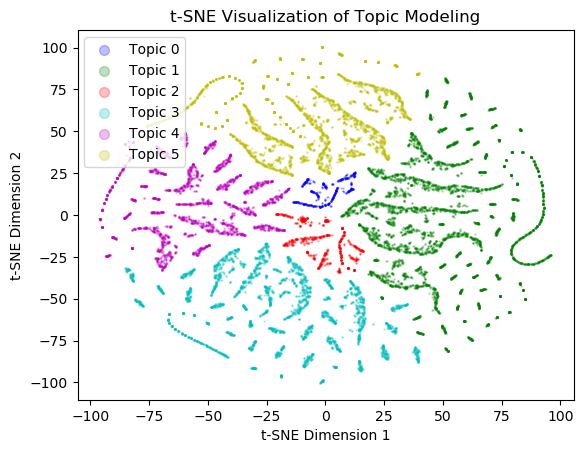

In [38]:
# LDA TSNE Graph
tsne_visualization(best_lda['Document-Topic Distribution'], 0.75)

LENGTH:
57287

COUNTS:
[[    0  9362]
 [    1 12734]
 [    2  8968]
 [    3 10223]
 [    4  8207]
 [    5  7793]]



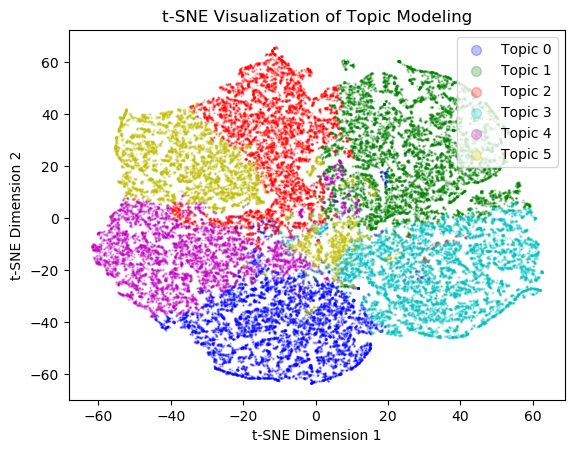

In [39]:
# NMF TSNE Graph
tsne_visualization(best_nmf['Document-Topic Distribution'], 0.0)

## <span style='color:navy'>Having in mind that LDA and NMF are based on different underlying principles, and the distribution of documents across topics is influenced by how each model represents topics and documents, the choice of which model to use will ultimately depend on the specific use case.</span>

## <span style='color:navy'>To help decide, I would advise the following:</span>

### * Use NMF if you need distinct, non-overlapping topics (e.g., when documents clearly belong to one topic).
### * Use LDA if you expect documents to be mixtures of multiple topics and want to capture that complexity.

## <span style='color:navy'>Therefore, looking at these graphs alone won't be enough to decide whether LDA or NMF is the right choice for this use case. The best approach, I believe, would be to compare the results of both models using evaluation metrics such as topic coherence, perplexity, and perhaps even manual inspection of the topics. This will help determine which model best fits the specific data and the goals I am pursuing.</span>

## Creating a biplot visualization usingusing the pyLDAvis package  for the best LDA model, experimenting with values of the relevance metric

In [40]:
lda_plot = pyLDAvis.sklearn.prepare(best_lda['model'], best_lda['vec'], dtm_vectorizer, R = 10)
pyLDAvis.display(lda_plot)

## Providing a clear description of the abstract topics found by each model and presenting this information neatly

## <span style='color:navy'>Exploring LDA models and providing a description of the abstract topics:</span>

### * LDA Model (1 topics, CountVectorizer): based on top words, the topic appears to be center around financial products (account, loans), payments / debt issues, and reports associated with them.

### * LDA Model (1 topics, TfidfVectorizer): based on top words, the topic appears to be center around financial management (payment, loan, debt) , financial products (account, loan, cards), reporting (report, company). Comparing to the previous one, this topic appears to be more broad.

### * LDA Model (2 topics, CountVectorizer): 
### - The first topic appears to be related to debt collection and disputes, and credit reporting.
### - The second topic appears to be related to financial products and payments.

### * LDA Model (2 topics, TfidfVectorizer):
###   - The first topic appears to be related to debt collection and disputes, and credit reports (including references to Experian and credit agencies).
###   - The second topic appears to be related to financial products and payments / charges.

### * LDA Model (3 topics, CountVectorizer):
###   - The first topic appears to be center around mortgage, loans and payment modifications.
###   - The second topic appears to be center around financial products and payments.
###   - The third topic appears to be center around credit reports, debt collection and disputes.

### * LDA Model (3 topics, TfidfVectorizer):
###   - The first topic appears to be related to loans, mortgages payment modifications but introducing other terms such as fees, check and account. It also includes terms related to specific banks such as America and Fargo.
###   - The second topic appears to be related to financial products and payments / charges.
###   - The third topic appears to be related to debt collection and disputes, and credit reporting (including references to Experian and credit agencies).

### * LDA Model (4 topics, CountVectorizer):
###   - The first topic appears to be center around mortgage, loans and payment modifications.
###   - The second topic appears to be center around financial payments and charges.
###   - The third topic appears to be center around consumers complaints and disputes.
###   - The fourth topic appears to be center around credit reports, debt collection and disputes.

### * LDA Model (4 topics, TfidfVectorizer):
###   - The first topic appears to be related to mortgages, loans and property foreclosure.
###   - The second topic appears to be related to financial payments and charges.
###   - The third topic appears to be related to credit reports / bureau, disputes, referencing to Experian and TransUnion.
###   - The fourth topic appears to be center around debt collection and contacting credit agencies.

### * LDA Model (6 topics, CountVectorizer):
###   - The first topic appears to be center around mortgage management (taxes, escrow, insurance, payments).
###   - The second topic appears to be center around financial payments and charges.
###   - The third topic appears to be center around consumers complaints and disputes.
###   - The fourth topic appears to be center around debt collection, contacting agencies.
###   - The fifth topic appears to be center around credit reports / bureau, disputes / inquiries, including references to Experian and TransUnion.
###   - The sixth topic appears to be center around loan and mortgages payment modifications.

### * LDA Model (6 topics, TfidfVectorizer):
###   - The first topic appears to be related to mortgages (property, sale, escrow) and payment modification.
###   - The second topic appears to be related to financial payments and charges.
###   - The third topic appears to be related to debt collection and disputes, including terms as court and validation.
###   - The fourth topic appears to be center around debt collection and contacting companies.
###   - The fifth topic appears to be center around credit reports, disputes resolution, inquiries, including references to Experian and TransUnion.
###   - The sixth topic appears to be center around loan and mortgages payments modifications, financial offers.

### * LDA Model (8 topics, CountVectorizer):
###   - The first topic appears to be center around mortgage mangement (taxes, escrow, insurance, payments), including references to Bank of America.
###   - The second topic appears to be center around financial payments and charges.
###   - The third topic appears to be center around consumers complaints and disputes.
###   - The fourth topic appears to be center around debt collection, disputes, with additional terms such as law and file.
###   - The fifth topic appears to be center around credit reports, inquiries and identity theft, including a reference to Experian. With additional terms such as bankruptcy and car.
###   - The sixth topic appears to be center around loan and mortgages payment modifications.
###   - The seventh topic appears to be center around credit bureau, disputes, including a reference to Experian.
###  - The eight topic appears to be center around credit cards (fees, offers, purchases, charges, account), a reference to Citibank is also included.

### * LDA Model (8 topics, TfidfVectorizer):
###   - The first topic appears to be related to financial transactions, including references to Bank of America and Wells Fargo.
###   - The second topic appears to be related to financial payments and charges, including additional terms such as late and balance.
###   - The third topic appears to be related to debt collection and disputes, including terms as court and validation.
###   - The fourth topic appears to be center around debt collection and contacting companies.
###   - The fifth topic appears to be center around credit reports / score, disputes, inquiries, including a reference to Experian and TransUnion. Additional terms such as identity, with potential broader connections with the rest of the top words.
###   - The sixth topic appears to be center around loan, payments, students, mile promotion, bonus, and a reference to Citibank.
###   - The seventh topic appears to be center around mortgage management (loan, payment, escrow, insurance, taxes, late payments). The term vehicule is also included, not quite related to rest of top words though.
###   - The eight topic appears to be center around mortgages, loans and property foreclosure.

### * LDA Model (10 topics, CountVectorizer):
###   - The first topic appears to be center around money deposits, funds, fees, including a reference to Bank of America and Wells Fargo.
###   - The second topic appears to be center around financial payments and contacting customers.
###   - The third topic appears to be center around disputes resolution and provide a response to customers.
###   - The fourth topic appears to be center around debt collection and contacting agencies.
###   - The fifth topic appears to be center around credit reports/ score, inquiries, social security. With additional terms such as vehicle, hard, and remove.
###   - The sixth topic appears to be center around loan and mortgages payment and modifications.
###   - The seventh topic appears to be center around mortgages management(late payments, fees, taxes, insurance, escrow, loan).
###   - The eight topic appears to be center around credit cards (charges, account, fees, balance), a reference to Citibank is also included.
###   - The ninth topic appears to be center around credit report / bureau, disputes, including references to credit agencies such as Experian and TransUnion.
###   - The tenth topic appears to be center around credit cards (fees, offers, purchases, charges, account), a reference to Citibank is also included.

### * LDA Model (10 topics, TfidfVectorizer):
###   - The first topic appears to be related to money deposits, charges, fees, overdrafts, including references to Bank of America.
###   - The second topic appears to be related to financial payments / charges, late payments, and fees.
###   - The third topic appears to be related to credit reports, disputes, social security, including references to Experian and TransUnion. The term live is also present, not quite easy to relate to the rest of words.
###   - The fourth topic appears to be center around debt collection and contacting companies.
###   - The fifth topic appears to be center around credit reports / score, inquiries, including a reference to Experian and TransUnion. Additional terms such as authorize, hard, and remove.
###   - The sixth topic appears to be center around loan, payments, students, mile promotion, bonus, and a reference to Citibank.
###   - The seventh topic appears to be center around mortgage management (loan, payment, sale, house). The term car is also included, not quite related to rest of top words though.
###   - The eight topic appears to be center around mortgage management (loans, modifications, payments, sale, house).
###   - The ninth topic appears to be center around credit bureau / reports, disputes, debt collection, including a reference to Experian.
###   - The tenth topic appears to be center around to mortgages, loans and property foreclosure. Including other terms such as bankruptcy, court, discharge and chapter.

## <span style='color:navy'>Exploring NMF models and providing a description of the abstract topics:</span>
    
### * NMF Model (1 topics, CountVectorizer): based on top words, the topic appears to be center around financial account / loan management (payment, checks, reports).

### * NMF Model (1 topics, TfidfVectorizer): based on top words, the topic appears to be center around financial management (payment, debt) , financial products (account, loan, cards), reporting (report, company).

### * NMF Model (2 topics, CountVectorizer):  
### - The first topic appears to be related to account / credit cards charges, debt and reports.
### - The second topic appears to be related to mortgage and loan payments.

### * NMF Model (2 topics, TfidfVectorizer):
### - The first topic appears to be related to mortgage, loans and credit cards (fees, payments, charges).
### - The second topic appears to be related to debt collection, disputes, credit reports / agencies, including a reference to Experian.

### * NMF Model (3 topics, CountVectorizer):
### - The first topic appears to be center around financial payments and charges.
### - The second topic appears to be center around mortgage and loans payments.
### - The third topic appears to be center around credit reports, debt collection and disputes.

### * NMF Model (3 topics, TfidfVectorizer):
### - The first topic appears to be related to loans and mortgages, payment / modifications but introducing other terms such as late, call, tell. It also includes terms related to specific banks such as Fargo.
### - The second topic appears to be related to debt collection, dispute, credit reports / agencies, including a reference to Experian.
### - The third topic appears to be related to financial charges, fees, balance, including a reference to Bank of America.

### * NMF Model (4 topics, CountVectorizer):
### - The first topic appears to be center around financial account / credit cards charges, fees, balance, payments.
### - The second topic appears to be center around mortgage and loan payments, modifications.
### - The third topic appears to be center around debt collection, disputes, credit agencies.
### - The fourth topic appears to be center around credit cards charges, fees, money, including a reference to Bank of America.

### * NMF Model (4 topics, TfidfVectorizer):
### - The first topic appears to be related to mortgages payments and modifications, late payments.
### - The second topic appears to be related to credit reports, inquiries, disputes. Including references to Experian and TransUnion.
### - The third topic appears to be related to account balance, fees, charges, including a reference to Bank of America.
### - The fourth topic appears to be center around debt collection and contacting agencies.

### * NMF Model (6 topics, CountVectorizer):
### - The first topic appears to be center around account money deposits, fees, funds, reports, balance.
### - The second topic appears to be center around mortgages and loans modifications.
### - The third topic appears to be center around debt collection, disputes, credit reports / agencies, including a reference to Experian.
### - The fourth topic appears to be center around money deposit, funds, fees, fraud claims, branches, including a reference to Bank of America.
### - The fifth topic appears to be center around credit cards charges, fees, payments, contact efforts related to these terms.
### - The sixth topic appears to be center around mortgage management (balance, statement, payments, fees).

### * NMF Model (6 topics, TfidfVectorizer):
### - The first topic appears to be related to mortgages, loans and property foreclosure.
### - The second topic appears to be related to credit reports, inquiries, disputes, including references to Experian and TransUnion.
### - The third topic appears to be related to account money deposits, fees, funds and overdraft.
### - The fourth topic appears to be center around debt collection and contacting companies.
### - The fifth topic appears to be center around mortgage management (balance, statement, payments, fees).
### - The sixth topic appears to be center around credit cards charges, balance, including references to Citibank and contact efforts.

### * NMF Model (8 topics, CountVectorizer):
### - The first topic appears to be center around account balance, money deposits / transfers, funds, fees, including a reference to Wells Fargo.
### - The second topic appears to be center around mortgages, loans and property foreclosure, modifications.
### - The third topic appears to be center around debt collection, contacting agencies.
### - The fourth topic appears to be center around fraud claims, menoey deposits, fees, funds, branches, including references to Bank of America.
### - The fifth topic appears to be center around credit cards charges, contacting efforts related to it.
### - The sixth topic appears to be center around mortgages statements and payments.
### - The seventh topic appears to be center around credit bureau, disputes, credit agencies including a reference to Experian and TransUnion.
### - The eight topic appears to be center around late payments, balance, charges, fees, statements.


### * NMF Model (8 topics, TfidfVectorizer):
### - The first topic appears to be related to Contacting effors (letter, phone)
### - The second topic appears to be related to credit reports / bureau, inquiries, disputes, including references to Experian and TransUnion.
### - The third topic appears to be related to account balance, deposits, disputes.
### - The fourth topic appears to be center around debt collection, collector agencies /companies, validations.
### - The fifth topic appears to be center around mortgage balance, statemenst, payments, fees.
### - The sixth topic appears to be center around credit cards fees, charges, balance, purchases, statements, payments, including a reference to Citibank.
### - The seventh topic appears to be center around money deposits, funds, fees, overdraft, including a reference to Bank of America.
### - The eight topic appears to be center around mortgages, loans and property foreclosure.

### * NMF Model (10 topics, CountVectorizer):
### - The first topic appears to be center around account balance, money deposit / transfer, funds, fees, including a reference to Wells Fargo.
### - The second topic appears to be center around mortgage management (paymente, statement).
### - The third topic appears to be center around debt collection, disputes, collector agencies, consumer.
### - The fourth topic appears to be center around student loan (process time, rate, lender, application, refinance, modification).
### - The fifth topic appears to be center around credit cards (balance, fees, charges, purchases, statements, service, issues) customer. A reference to Citibank is included.
### - The sixth topic appears to be center around fraud claims, money deposit, balance, payments, charges, fees. A reference to Bank of America is included.
### - The seventh topic appears to be center around credit reports / bureau, disputes. References to credit agencies such as Experian and TransUnion are also included.
### - The eight topic appears to be center around payments, fees, charges, balance.
### - The ninth topic appears to be center around contact efforts (call, receive, phone, letter). Adiitional words like state, time, days are included in the top 10 words.
### - The tenth topic appears to be center around mortgage, property foreclosure, insurance, modifications.

### * NMF Model (10 topics, TfidfVectorizer):
### - The first topic appears to be related to contacting companies (phone, call, receive), with additional words like state, not quite related to the other top words though.
### - The second topic appears to be related to credit bureay / report / score, inquiries, including a reference to TransUnion. Additional words like address, item and identity, are part of the top 10 words as well.
### - The third topic appears to be related to account balance, monet deposit, funds.
### - The fourth topic appears to be center around debt collection and collector companies.
### - The fifth topic appears to be center around mortgage statement, balance, escrow, payments, fees).
### - The sixth topic appears to be center around credit cards (fees, charges, payments, balance, purchases, statement). A reference to Citibank is included.
### - The seventh topic appears to be center around money deposit, cash, overdraft, funds, fees. References to Bank of America are included.
### - The eight topic appears to be center around mortgage management (loans, modifications, payments, property, lender, refinance). The term student is also included in the top 10 words.
### - The ninth topic appears to be center around dispute, verification request, file, Fair Credit Reporting Act (FCRA). Additional words included in the top 10 words are: letter, Experian, delete.
### - The tenth topic appears to be center around to mortgages, loans and property foreclosure, sale, house, modifications.

## <span style='color:navy'>Discussing which model has done the best job of finding topics for the use case and justifying this by referring to the analysis and visualizations</span>

## <span style='color:navy'>Based on the analysis of the top 10 words and abstract descriptions for each topic, I conclude that LDA models, particularly with CountVectorizer, are better suited for this use case. The topics identified by LDA are more intuitive and directly aligned with financial themes, avoiding the inclusion of irrelevant or random words that don't fit well with the other terms in the topic. While NMF models offer good topic separation, LDA provides a more coherent and easily interpretable breakdown of financial data, which is crucial for applications such as customer service, where efficiently routing customer requests to the appropriate department is essential.</span>

## <span style='color:navy'>The biplot visualization further supports the choice of the LDA model with 6 topics (CountVectorizer). After exploring visualizations for other LDA models, it's clear that models with 4 topics or fewer tend to be overly simplistic and lack the necessary granularity, while models with 8 or more topics tend to suffer from excessive overlap. The LDA model with 6 topics strikes a balance, offering sufficiently granular topics without excessive overlap, making it the most suitable choice for this application.</span>

# Conclusion

## Providing a summary to specify which model was chosen (if any) and how it addresses the use case to the benefit of stakeholders. Restating the quantitative and qualitative reasons for this choice. If none of the models were satisfactory, speculating on what you could try to get better results, or if you don't think any model can work, explaining why it is not possible to train a good model for this use case with this data

## <span style='color:navy'>Based on the analysis and the results obtained, I conclude that the LDA models, particularly the one using CountVectorizer (6 topics), is the most suitable for this use case, for the following reasons:</span>
    
### * <span style='color:navy'>Balanced Perplexity: With a perplexity of 357.97, this model strikes a good balance between fit and interpretability, outperforming models with 8 or 10 topics in terms of both coherence and relevance.</span>

### * <span style='color:navy'>Coherence and Interpretability: The topics from this model are more coherent and less overlapping than those from models with more topics, which makes it easier to derive clear insights from the output. This is especially important in customer service applications, where clear topic distinctions are essential for accurate query routing.</span>

### * <span style='color:navy'>Practical Use: The topics generated by this model align well with finance-related terms and are more likely to be useful in practice, helping to categorize and direct customer queries efficiently.</span>

## <span style='color:navy'>In summary, the LDA with CountVectorizer (6 topics) model offers a strong combination of interpretability and performance, making it the best choice for this particular use case within the financial industry.</span>